## Bayesian Optimisation with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a Gradient Boosting Regressor, using the open source Python package [Scikit-Optimize](https://scikit-optimize.readthedocs.io/).

Scikit-Optimize offers an interface that allows us to do the Optimization in a similar way to the GridSearchCV or RandomizedSearchCV from Scikit-learn, through the class [BayesSearchCV](https://scikit-optimize.readthedocs.io/en/latest/auto_examples/sklearn-gridsearchcv-replacement.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# note that we only need to import the wrapper
from skopt import BayesSearchCV

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


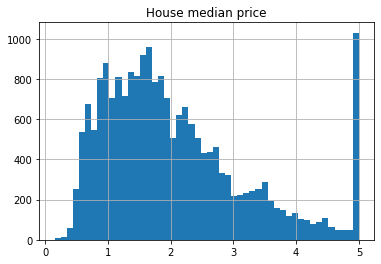

In [3]:
y.hist(bins=50)
plt.title("House median price")
plt.show()

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

## Define the model and Hyperparameter Space

In [5]:
# set up the model

gbm = GradientBoostingRegressor(random_state=0)

In [6]:
# hyperparameter space - note that we define it as 
# we would do for Scikit-learn classes

param_grid = {
    'n_estimators': (10, 120), 
    'min_samples_split': (0.001, 0.99, 'log-uniform'),
    'max_depth': (1, 8),
    'loss': ['squared_error', 'quantile', 'huber'],
}

## Bayesian Optimization

The rest of the notebook is very similar to that of RandomizedSearchCV, because the BayesSearchCV makes sure to bring forward all of Scikit-learn functionality.

In [7]:
# set up the search
search = BayesSearchCV(
    estimator=gbm,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=50,
    random_state=10,
    n_jobs=4,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
              n_jobs=4, random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'loss': ['squared_error', 'quantile', 'huber'],
                             'max_depth': (1, 8),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (10, 120)})

In [8]:
# the best hyperparameters are stored in an attribute

search.best_params_

OrderedDict([('loss', 'squared_error'),
             ('max_depth', 8),
             ('min_samples_split', 0.0038644180871806365),
             ('n_estimators', 120)])

In [9]:
# the best score

search.best_score_

-0.22879816380194642

In [10]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(50, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.205348,0.021003,0.013993,0.001632,squared_error,3,0.044228,80,"{'loss': 'squared_error', 'max_depth': 3, 'min...",-0.304791,-0.298579,-0.292968,-0.298779,0.004829,35
1,3.249137,0.344395,0.009994,0.000002,huber,2,0.308189,76,"{'loss': 'huber', 'max_depth': 2, 'min_samples...",-0.396707,-0.394492,-0.380090,-0.390430,0.007367,40
2,2.683460,0.045295,0.015325,0.006177,huber,3,0.002288,48,"{'loss': 'huber', 'max_depth': 3, 'min_samples...",-0.340910,-0.336193,-0.322526,-0.333210,0.007796,38
3,8.739655,0.021160,0.021320,0.000942,huber,5,0.001897,90,"{'loss': 'huber', 'max_depth': 5, 'min_samples...",-0.266633,-0.251035,-0.242927,-0.253532,0.009838,27
4,4.038350,0.033461,0.011659,0.000471,huber,4,0.054687,54,"{'loss': 'huber', 'max_depth': 4, 'min_samples...",-0.303920,-0.298395,-0.293754,-0.298690,0.004155,34


Text(0.5, 0, 'Hyperparameter combinations')

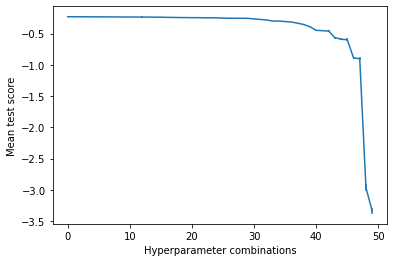

In [11]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [12]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train roc_auc: ', mean_squared_error(y_train, X_train_preds))
print('Test roc_auc: ', mean_squared_error(y_test, X_test_preds))

Train roc_auc:  0.08219072470734878
Test roc_auc:  0.22550551767877883
